In [1]:
import os
import numpy
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

##  read inputs, handle missing values, scale input/output, convert to float32

In [2]:
def load_data(path, test=False, col=None):
    """ Load the data from path
        by default it assums the training data and
        loads all the columns
    """
    df = read_csv(os.path.expanduser(path))
    # the Image column is the pixel values separated by space
    # convert the values to numpy array
    df['Image'] = df['Image'].apply(lambda im: numpy.fromstring(im, sep=' '))
    
    # if you want only a subset of columns, passed as col to input
    if col:
        df = df[list(col)+['Image']]
    
    # some keypoints have missing valuses
    # deal with them in handle_missing
    # print(df.count())
    df = handle_missing_values(df)
    # print(df.count())
    
    # the Image column contains pixel values 
    # it is a list separated by space
    # convert it into numpy array using np.vstack
    # also scale them to [0, 1]
    X = numpy.vstack(df['Image'].values) / 255.
    
    # convert values to float32
    X = X.astype(numpy.float32)
    
    # for training data, manipulate target values
    # scale the target values
    # shuffle data
    # Convert it to float 32
    if not test:
        Y = df[df.columns[:-1]].values
        Y = (Y - 48) / 48  # scale target coordinates to [-1, 1]
        X, Y = shuffle(X, Y, random_state =54)  # shuffle train data
        Y = Y.astype(numpy.float32)
    else:
        Y = None

    return X, Y
    
def handle_missing_values(df):
    """For the time being, just drop all the samples with missing values
    """
    newdf= df.dropna()
    return newdf

In [3]:
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'
X, Y = load_data(FTRAIN)

This implementation is based on Lisa-lab's tutorial on theano

### first write a multi-target linear regression

In [4]:
import theano
import theano.tensor as T

Using gpu device 0: GeForce GTX 960


In [5]:
class linear_regresion(object):
    """multi-target linear regression 
    Fully described with weight matrix :math:'W'
    and bias vectir :math:'b'.       
    """
    def __init__(self, input, n_in,n_out):
        """initialize parameters of linear regression
        :type input: theano.tensir.TensorType
        :param input: the symbolic variable that describes
        the input of the architecture (one minibatch)
        
        :type n_in: int
        :param n_in: number of input units, the dimesion of
        the space data points lie in
        
        :type n_out: int 
        :param n_out: number of output units, the number of
        target variables to predict
        
        """
        
        # initializing the weghts matrix by zero and shape(n_in,n_out)
        self.W= theano.shared(
            value=numpy.zeros(
                (n_in,n_out),
                dtype=theano.config.floatX
            ),
            name='W',
            borrow=True
        )
        # initialize bias
        self.b = theano.shared(
            value=numpy.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b',
            borrow=True
        )
       
        # symbolic expression of computing the output using W and b
        self.y_pred=T.dot(input,self.W)+self.b# make sure it is correct
        
        # parameters of the model
        self.param=[self.W,self.b]
        
        # keep track of model input
        self.input=input
        
        # define the loss function
    def loss_MSE(self,y):
        """returns the MSE error of prediction of the model
        :type y: theano.tensor.TensorType
        :param y: the vector that gives each samples correct prediction value
        """
        #  T.sum(T.sqr(targets-outputs),axis=1) 
        # I use averaging to         
        return T.mean(T.sqr(y-self.y_pred))#,axis=[0,1])
    def errors(self, y):
        """return the number of errors in minibatch
        
        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example 
        the correct target values
        """
        # check if the dimension of y and y_pred is the same
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y',y.type, 'y_pred', self.y_pred.type)
            )
        return T.mean(T.neq(self.y_pred,y))
        

In [6]:
def shared_dataset(X,y,borrow=True):
    """Load data into shared variables    
    """
    shared_x=theano.shared(numpy.asarray(X,
                                        dtype=theano.config.floatX),
                          borrow=borrow)
    shared_y= theano.shared(numpy.asarray(y,
                                        dtype=theano.config.floatX),
                          borrow=borrow)
    return shared_x, shared_y

In [7]:
# generate train and validation sets
from sklearn.cross_validation import train_test_split
train_set_x, valid_set_x, train_set_y, valid_set_y = train_test_split(
    X, Y, test_size=0.3, random_state=42
)
train_set_x, train_set_y = shared_dataset(train_set_x, train_set_y)
valid_set_x, valid_set_y = shared_dataset(valid_set_x, valid_set_y)

### sgd optimization

In [8]:
learning_rate=0.01
n_epochs=1000
batch_size=10

In [9]:
#compute the number of mini batches
n_train_batches= train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size

In [10]:
print('...building the model')

# allocate symbolic variable for data
index = T.lscalar()

# generate symbolic variable for data - x, y represent a single batch
x= T.matrix('x')
y=T.matrix('y')

# construct the regressor
linear_regressor = linear_regresion(input=x , n_in= 96 * 96, n_out=30)

...building the model


In [11]:
# compile a theano function to report the validation cost
validate_model = theano.function(
    inputs=[index],
    outputs=linear_regressor.loss_MSE(y),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

In [12]:
# the cost we minimise is MSE
cost = linear_regressor.loss_MSE(y)

In [13]:
# compute the gradient of cost
g_W = T.grad(cost=cost, wrt= linear_regressor.W)
g_b = T.grad(cost=cost, wrt= linear_regressor.b)

In [14]:
# how to update parameters of the model
updates=[(linear_regressor.W, linear_regressor.W - learning_rate * g_W),
        (linear_regressor.b, linear_regressor.b - learning_rate * g_b)]


In [15]:
# compile a theano function that concurrently returns the cost
# and updates the model based on the update rules in updates
train_model = theano.function(
    inputs=[index],
    outputs=cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

In [16]:
# run with early stopping
# early-stopping parameters
patience = 1000  # look as this many examples regardless
patience_increase = 10  # wait this much longer when a new best is
# found
improvement_threshold = 0.9999  # a relative improvement of this much is
                                # considered significant
validation_frequency = min(n_train_batches, patience // 10)
                        # go through this many
                        # minibatche before checking the network
                        # on the validation set; in this case we
                        # check every epoch

In [17]:
best_validation_loss = numpy.inf
test_score = 0.
# start_time = timeit.default_timer()

In [18]:
done_looping = False
epoch = 0
history_validation_loss=numpy.inf#numpy.empty([])
history_train_loss=numpy.inf#numpy.empty([])

In [19]:
while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):
        minibatch_avg_cost =  train_model(minibatch_index)
        # iteration number
        iter = (epoch - 1) * n_train_batches + minibatch_index
        
        if (iter + 1) % validation_frequency == 0:
            # compute zero-one loss on validation set
            validation_losses = [validate_model(i)
                                 for i in range(n_valid_batches)]
            history_validation_loss = numpy.append(history_validation_loss,numpy.mean(validation_losses))
            
            train_losses = [train_model(i)
                            for i in range(n_train_batches)]
            history_train_loss = numpy.append(history_train_loss,numpy.mean(train_losses))
#             print(
#                 'epoch %i, minibatch %i/%i, validation error %f %%' %
#                 (
#                     epoch,
#                     minibatch_index + 1,
#                     n_train_batches,
#                     this_validation_loss 
#                 )
#             )
            if patience <= iter:
                #one_looping = True
                break
                

### plot train valid curves

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

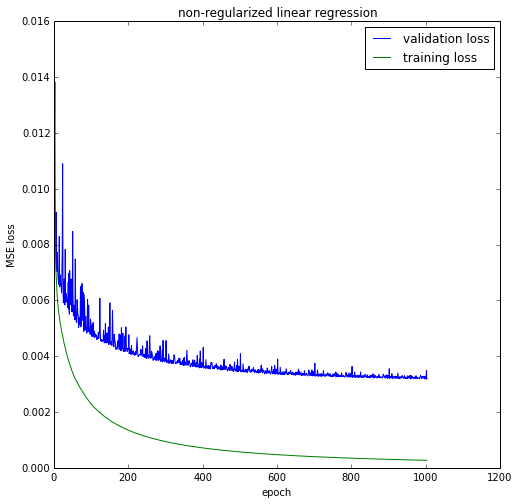

In [27]:
plt.figure(figsize=(8, 8))
valid_train_curves=plt.subplot(111)
valid_train_curves.plot(history_validation_loss, label="validation loss")
valid_train_curves.plot(history_train_loss, label="training loss")
valid_train_curves.legend(loc='best')
valid_train_curves.set_xlabel('epoch')
valid_train_curves.set_ylabel('MSE loss')
valid_train_curves.set_title('non-regularized linear regression')

###  MLP implementation